# Predict GAD in students
## Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import category_encoders as ce 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed to last 3 digits of my student ID as random seed for reproducibility
seed_value = 417
pd.set_option('display.max_columns', None)

# Preprocessing

In [31]:
# fetch dataset 
# Rename cols
raw_df = pd.read_csv('dataset.csv')
df = raw_df.copy()
col_names_map = {
  '1. Have you read Participant Information Sheet?': 'c1',
  '2. Do you understand you won\'t be able to withdraw consent because of anonymised data?': 'c2',
  '3. Are you aged 18 years or above?': 'c3',
  '4. Do you agree to take part in questionnaire out of your own free will?': 'c4',
  '5. Do you have a part-time job or full time job?': 'have_job',
  '6. Are you an international student?': 'international_student',
  '7. Do you have to support your family financially?': 'support_family_financially',
  '8. How do you rate your financial worries?': 'financial_worries',
  '9. How satisfied you are with your living arrangements?': 'living_arrangements',
  '10. How do you rate your current level of academic stress?': 'academic_stress',
  '11. How do you feel about your workload this or last semester?': 'workload',
  '12. How often do you feel supported by your friends?': 'suppported_by_friends',
  '13. How often do you feel supported by your family?': 'supported_by_family',
  '14. How often do you seek support from faculty or staff?': 'seek_staff_support',
  '15. How many hours of sleep do you typically get per night?': 'sleep_time',
  '16. How often do you exercise per week? (Any kind of exercise counts walking, jogging, gym etc)': 'exercise',
  '17. How would you rate your overall diet?': 'diet',
  '18. What is your degree level?': 'degree_level',
  '19. Have you ever faced discriminatory treatment from any of the student or University staff?': 'faced_discrimination',
  '20. Are you involved in sports? (Any sports activity at least twice a month)': 'involved_in_sports',
  '21. Do you have a circle of friends you like?': 'friends_circle',
  '22. What are your drinking habits? (Alcoholic drinks)': 'drinking_habits',
  '23. What is your Gender?': 'gender',
  '24. Enter your age range?': 'age_range',
  '25. Do you suffer from any chronic Physical health Problem?': 'chronic_health_problem',
  '26. Which study year you are in?': 'study_year',
  '27. How satisfied have you been with your overall well-being over the past two months?': 'overall_well_being',
  '28. During the PAST 7 DAYS, I have…': 'gad_0',
  '28.1. felt moments of sudden terror, fear or fright': 'gad_1',
  '28.2. felt anxious, worried, or nervous': 'gad_2',
  '28.3. had thoughts of bad things happening, such as family tragedy, ill health, loss of a job, or accidents': 'gad_3',
  '28.4. felt a racing heart, sweaty, trouble breathing, faint, or shaky': 'gad_4',
  '28.5. felt tense muscles, felt on edge or restless, or had trouble relaxing or trouble sleeping': 'gad_5',
  '28.6. avoided, or did not approach or enter, situations about which I worry': 'gad_6',
  '28.7. left situations early or participated only minimally due to worries': 'gad_7',
  '28.8. spent lots of time making decisions, putting off making decisions, or preparing for situations, due to worries': 'gad_8',
  '28.9. sought reassurance from others due to worries': 'gad_9',
  '28.10. needed help to cope with anxiety (e.g., alcohol or medication, superstitious objects, or other people)': 'gad_10'
}

# Rename cols and Remove consent cols
# Overall well being col is dropped 
df = df.rename(columns = col_names_map)

# Apply the strip function to all values in the DataFrame
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Drop consent columns and an empty column with no data
df = df.drop(['c1', 'c2', 'c3', 'c4', 'gad_0'], axis=1)


categorical_cols = [
  'gender', 'study_year', 'degree_level', 'drinking_habits', 'diet', 'sleep_time',  'age_range']
binary_columns = [
  'have_job', 'international_student', 'support_family_financially', 'faced_discrimination', 
  'involved_in_sports', 'friends_circle', 'chronic_health_problem']
ordinal_categorical_cols = [
  'financial_worries', 'living_arrangements', 'academic_stress', 'suppported_by_friends',
  'supported_by_family', 'seek_staff_support',  'exercise', 'overall_well_being', 'workload']


## Remove missing values rows

In [32]:
# remove missing values rows
print(len(df) - len(df.dropna()), "rows deleted because of missing values.")
df = df.dropna()

2 rows deleted because of missing values.


## Map GAD column to the respective score and calculate gad score
## Then convert the score to respective categories of GAD

In [33]:
# Gad map
gad_map = {'Never': 0, 'Occasionally': 1, 'Half of the time': 2, 'Most of the time': 3, 'All of the time': 4}
for i in range(1,11):
  df[f'gad_{i}'] = df[f'gad_{i}'].map(gad_map)

  
# Calculate gad score and covert to classification bins
df['gad_score'] = df['gad_1'] + df['gad_2'] + df['gad_3'] + df['gad_4'] + df['gad_5'] + df['gad_6'] + df['gad_7'] + df['gad_8']  + df['gad_9'] + df['gad_10']
df.drop(['gad_{}'.format(i) for i in range(1,11)], axis=1, inplace=True)                                                                                                                                                   
# get gad_sum and del GAD columns 
# Define the bins and labels
bins = [0, 14, 24, 40]
labels = [0, 1, 2]
df['gad_scale'] = pd.cut(df['gad_score'], bins=bins, labels=labels, right=True, include_lowest=True).astype(int)
df.drop(['gad_score'], axis=1, inplace=True)

df['gad_scale'].value_counts()

# Create copy for exploratory analysis
edf = df.copy()
edf['gad_scale'] = edf['gad_scale'].map({0:'None-Mild', 1: 'Moderate', 2: 'Severe-Extreme'})
edf['gad_scale'].value_counts()

None-Mild         2964
Moderate           884
Severe-Extreme     416
Name: gad_scale, dtype: int64

In [35]:
for column in df.columns:
    print(column, '\t', df[column].unique())

have_job 	 ['No' 'Yes']
international_student 	 ['Yes' 'No']
support_family_financially 	 ['Yes' 'No']
financial_worries 	 ['Always' 'Sometimes' 'Often' 'Rarely' 'Never worried']
living_arrangements 	 ['Satisfied' 'Not satisfied' 'Very dissatisfied' 'Extremely satisfied']
academic_stress 	 ['Sometimes stressed' 'Often stressed' 'Always stressed' 'Rarely stressed']
workload 	 ['Just right' 'Too heavy' 'Too light']
suppported_by_friends 	 ['Always' 'Often' 'Sometimes' 'Rarely']
supported_by_family 	 ['Always' 'Sometimes' 'Often' 'Rarely']
seek_staff_support 	 ['Rarely' 'Sometimes' 'Often' 'Always']
sleep_time 	 ['6-8 hours' 'Less than 6 hours' 'More than 8 hours']
exercise 	 ['0 times' '3-5 times' '1-2 times' '6 or more times']
diet 	 ['Moderately healthy' 'Healthy' 'Unhealthy']
degree_level 	 ['Undergraduate' 'Postgraduate' 'Phd']
faced_discrimination 	 ['No' 'Yes']
involved_in_sports 	 ['No' 'Yes']
friends_circle 	 ['Yes' 'No']
drinking_habits 	 ['Never' 'Occasionally' 'Regularly' 'Onl

## Map binary Variables and ordinal categories

In [6]:
for col in binary_columns:
  df[col] = df[col].map({'Yes': 1, 'No':0})
  
ordinal_mapping = {
  'financial_worries': {'Never worried':0, 'Rarely':1, 'Sometimes':2, 'Often':3, 'Always':4 },
  'living_arrangements': {'Satisfied': 1, 'Extremely satisfied': 0, 'Not satisfied': 2, 'Very dissatisfied': 3},
  'academic_stress': {'Always stressed':3, 'Sometimes stressed':1, 'Often stressed':2, 'Rarely stressed': 0},
  'suppported_by_friends': {'Always':3, 'Often':2, 'Rarely':1, 'Sometimes': 0},
  'supported_by_family': {'Always':3, 'Often':2, 'Rarely':1, 'Sometimes': 0},
  'seek_staff_support': {'Always':3,'Rarely':0, 'Sometimes':1, 'Often':2},
  'exercise': {'0 times': 0, '3-5 times':2, '1-2 times':1, '6 or more times':3},
  'overall_well_being': {'Satisfied': 1, 'Extremely satisfied': 0 ,'Neutral': 2, 'Dissatisfied': 3, 'Very dissatisfied': 4},
  'workload': {'Too heavy':2, 'Just right':0, 'Too light': 1}

}


for col in ordinal_categorical_cols:
  for key in df[col].unique():
    if key not in ordinal_mapping[col]:
      raise AssertionError('Key {} in not mapped for column {}'.format(key, col))
  df[col] = df[col].map(ordinal_mapping[col])

Pedregosa, F., et al. (2011). "Scikit-learn: Machine Learning in Python." Journal of Machine Learning Research, 12, 2825-2830.

This foundational paper on the scikit-learn library explains various preprocessing techniques, including the treatment of ordinal data. It highlights how ordinal encoding can preserve the order of categories and provide meaningful numerical representations for machine learning algorithms.


## Encode the categorical columns with one hot encoding

In [8]:
import pandas as pd

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols)

## Split in train test
## Sample balancing using SMOTE and Random OverSampling

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Define the features (X) and target (y)
X = df_encoded.drop('gad_scale', axis=1)
y = df_encoded['gad_scale']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=seed_value)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
smote = SMOTE(random_state=seed_value)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Store the balanced datasets in a dictionary
balanced_datasets = {
    'oversampled': {
        'X_train': X_train_ros,
        'y_train': y_train_ros,
        'X_test': X_test,
        'y_test': y_test
    },
    'smote': {
        'X_train': X_train_smote,
        'y_train': y_train_smote,
        'X_test': X_test,
        'y_test': y_test
    }
}

# Display the shapes of the resulting DataFrames
print("Oversampled Data:")
print(f"X_train shape: {balanced_datasets['oversampled']['X_train'].shape}")
print(f"y_train shape: {balanced_datasets['oversampled']['y_train'].shape}")
print("Class distribution in y_train after Random Oversampling:")
print(balanced_datasets['oversampled']['y_train'].value_counts())

print("\nSMOTE Data:")
print(f"X_train shape: {balanced_datasets['smote']['X_train'].shape}")
print(f"y_train shape: {balanced_datasets['smote']['y_train'].shape}")
print("Class distribution in y_train after SMOTE:")
print(balanced_datasets['smote']['y_train'].value_counts())


Oversampled Data:
X_train shape: (7149, 40)
y_train shape: (7149,)
Class distribution in y_train after Random Oversampling:
0    2383
1    2383
2    2383
Name: gad_scale, dtype: int64

SMOTE Data:
X_train shape: (7149, 40)
y_train shape: (7149,)
Class distribution in y_train after SMOTE:
0    2383
1    2383
2    2383
Name: gad_scale, dtype: int64


# Standardizd and Apply PCA

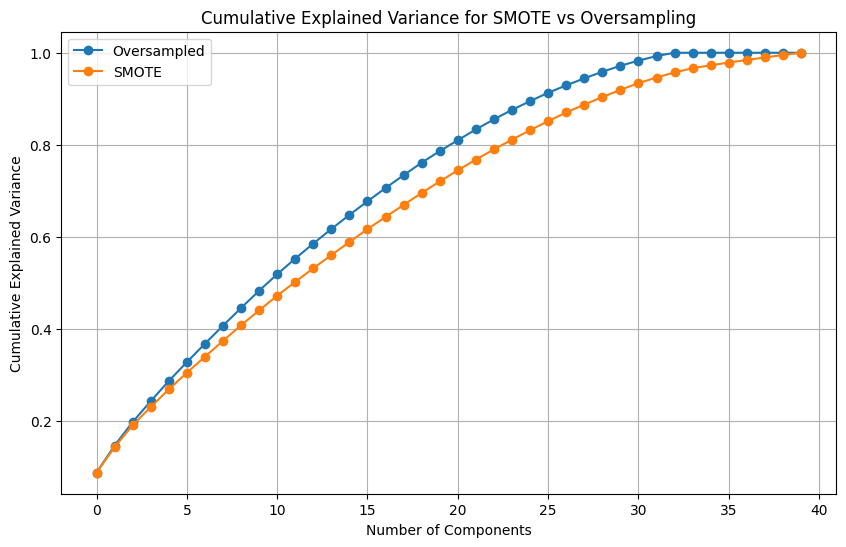

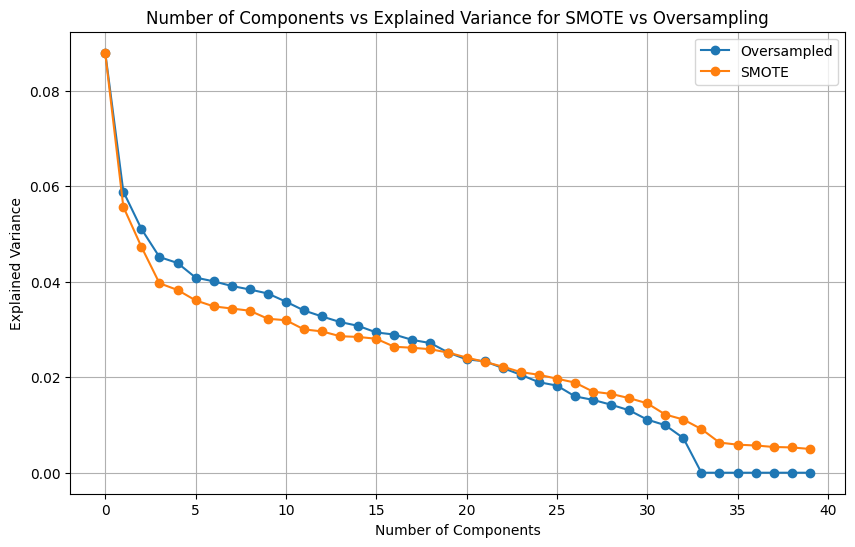

Number of components for 95% variance (Oversampled): 29
Number of components for 95% variance (SMOTE): 33


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_ros_scaled = scaler.fit_transform(balanced_datasets['oversampled']['X_train'])
X_train_smote_scaled = scaler.fit_transform(balanced_datasets['smote']['X_train'])
X_test_scaled = scaler.transform(balanced_datasets['smote']['X_test'])  # Scaling test data

# Apply PCA
pca_ros = PCA()
X_train_ros_pca = pca_ros.fit_transform(X_train_ros_scaled)

pca_smote = PCA()
X_train_smote_pca = pca_smote.fit_transform(X_train_smote_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance_ros = pca_ros.explained_variance_ratio_.cumsum()
cumulative_explained_variance_smote = pca_smote.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance_ros, label='Oversampled', marker='o')
plt.plot(cumulative_explained_variance_smote, label='SMOTE', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for SMOTE vs Oversampling')
plt.legend()
plt.grid(True)
plt.show()

# Plot number of components vs explained variance
plt.figure(figsize=(10, 6))
plt.plot(pca_ros.explained_variance_ratio_, label='Oversampled', marker='o')
plt.plot(pca_smote.explained_variance_ratio_, label='SMOTE', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Number of Components vs Explained Variance for SMOTE vs Oversampling')
plt.legend()
plt.grid(True)
plt.show()

# Decide on the number of components to keep (example: 95% variance)
n_components = 0.95

# Determine number of components for 95% variance explained
n_components_ros = (cumulative_explained_variance_ros >= n_components).argmax() + 1
n_components_smote = (cumulative_explained_variance_smote >= n_components).argmax() + 1

# Apply PCA with the chosen number of components
pca_ros_final = PCA(n_components=n_components_ros)
X_train_ros_pca = pca_ros_final.fit_transform(X_train_ros_scaled)
X_test_ros_pca = pca_ros_final.transform(X_test_scaled)  # Transform test data

pca_smote_final = PCA(n_components=n_components_smote)
X_train_smote_pca = pca_smote_final.fit_transform(X_train_smote_scaled)
X_test_smote_pca = pca_smote_final.transform(X_test_scaled)  # Transform test data

# Store the PCA-transformed datasets in the dictionary
balanced_datasets['oversampled']['X_train_pca'] = X_train_ros_pca
balanced_datasets['oversampled']['X_test_pca'] = X_test_ros_pca
balanced_datasets['smote']['X_train_pca'] = X_train_smote_pca
balanced_datasets['smote']['X_test_pca'] = X_test_smote_pca

# Display the number of components chosen for 95% variance explained
print(f"Number of components for 95% variance (Oversampled): {n_components_ros}")
print(f"Number of components for 95% variance (SMOTE): {n_components_smote}")


# Apply all classification algorithms and find best parameters by grid search.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns

# Define classifiers and their respective parameter grids
classifiers = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'ExtraTrees': ExtraTreesClassifier()
}

param_grids = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'ExtraTrees': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
}

# Store the best models for each technique
best_models = {'oversampled': {}, 'smote': {}}

# Hyperparameter tuning with GridSearchCV for each dataset
print("Best models and their parameters:")
for technique in ['oversampled', 'smote']:
    for name, clf in classifiers.items():
        grid_search = GridSearchCV(clf, param_grids[name], cv=10, scoring='accuracy', n_jobs=-1)
        grid_search.fit(balanced_datasets[technique]['X_train_pca'], balanced_datasets[technique]['y_train'])
        best_models[technique][name] = grid_search.best_estimator_
        print(f"{technique} - {name}: {grid_search.best_estimator_.get_params()}")


Best models and their parameters:
oversampled - SVM: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
oversampled - KNN: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
oversampled - RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
oversampled - AdaBoost: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learn

In [18]:
best_models

{'SVM': SVC(C=10, probability=True),
 'KNN': KNeighborsClassifier(n_neighbors=3, weights='distance'),
 'RandomForest': RandomForestClassifier(n_estimators=200),
 'AdaBoost': AdaBoostClassifier(learning_rate=1, n_estimators=100),
 'ExtraTrees': ExtraTreesClassifier(max_depth=20, n_estimators=200)}

## Cross Validation

In [20]:
# Store results
results = []

# Evaluate models and collect results for each technique
for technique in ['oversampled', 'smote']:
    for name, model in best_models[technique].items():
        # 10-fold cross-validation scores
        cross_val_scores = cross_val_score(
            model, 
            balanced_datasets[technique]['X_train_pca'], 
            balanced_datasets[technique]['y_train'], 
            cv=10, 
            scoring='accuracy'
        )
        print(f"{technique} - {name} Cross-validation accuracy: {cross_val_scores.mean():.2f} (+/- {cross_val_scores.std() * 2:.2f})")

        # Evaluation on test set
        result = evaluate_model(
            f"{name} ({technique})", model, 
            balanced_datasets[technique]['X_train_pca'], 
            balanced_datasets[technique]['y_train'], 
            balanced_datasets[technique]['X_test_pca'], 
            balanced_datasets[technique]['y_test']
        )
        results.append(result)


oversampled - SVM Cross-validation accuracy: 0.98 (+/- 0.01)
oversampled - KNN Cross-validation accuracy: 0.92 (+/- 0.02)
oversampled - RandomForest Cross-validation accuracy: 0.99 (+/- 0.02)
oversampled - AdaBoost Cross-validation accuracy: 0.67 (+/- 0.02)
oversampled - ExtraTrees Cross-validation accuracy: 0.99 (+/- 0.02)
smote - SVM Cross-validation accuracy: 0.94 (+/- 0.13)
smote - KNN Cross-validation accuracy: 0.91 (+/- 0.07)
smote - RandomForest Cross-validation accuracy: 0.89 (+/- 0.24)
smote - AdaBoost Cross-validation accuracy: 0.74 (+/- 0.18)
smote - ExtraTrees Cross-validation accuracy: 0.89 (+/- 0.28)


# Visualise Results

Performance for SVM (smote):
Accuracy: 0.91
                precision    recall  f1-score   support

     None-Mild       0.91      0.98      0.95       581
      Moderate       0.93      0.73      0.82       181
Severe-Extreme       0.87      0.84      0.85        91

      accuracy                           0.91       853
     macro avg       0.91      0.85      0.87       853
  weighted avg       0.91      0.91      0.91       853



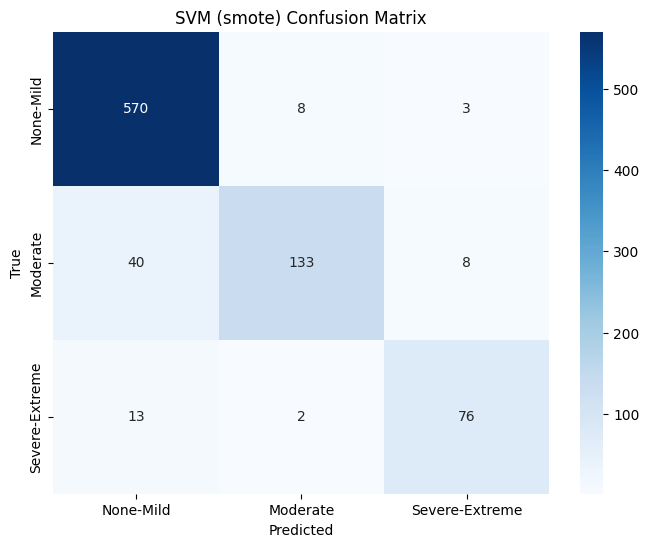

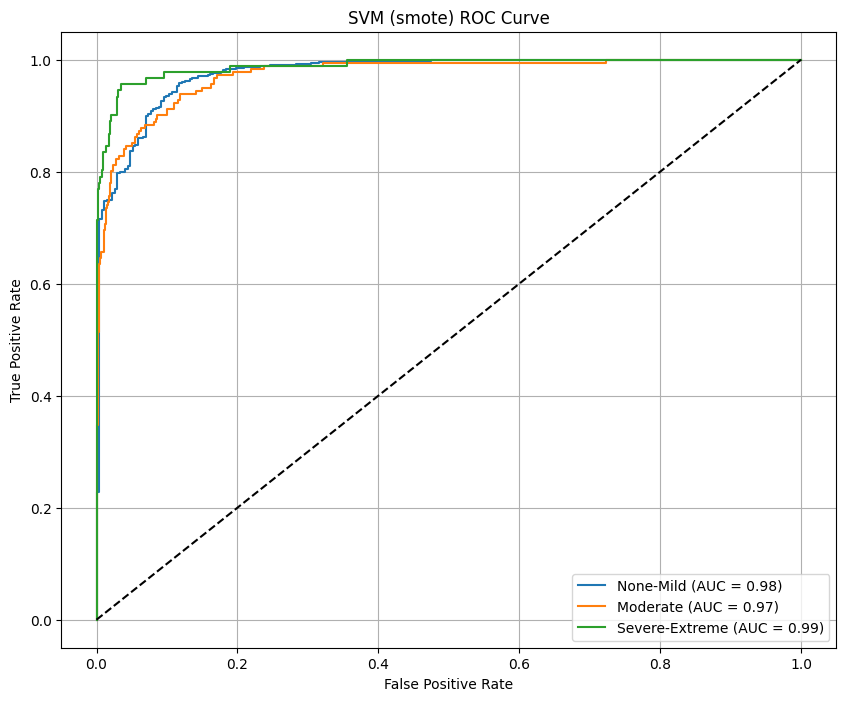

Performance for RandomForest (smote):
Accuracy: 0.86
                precision    recall  f1-score   support

     None-Mild       0.85      0.98      0.91       581
      Moderate       0.92      0.56      0.69       181
Severe-Extreme       0.79      0.68      0.73        91

      accuracy                           0.86       853
     macro avg       0.86      0.74      0.78       853
  weighted avg       0.86      0.86      0.85       853



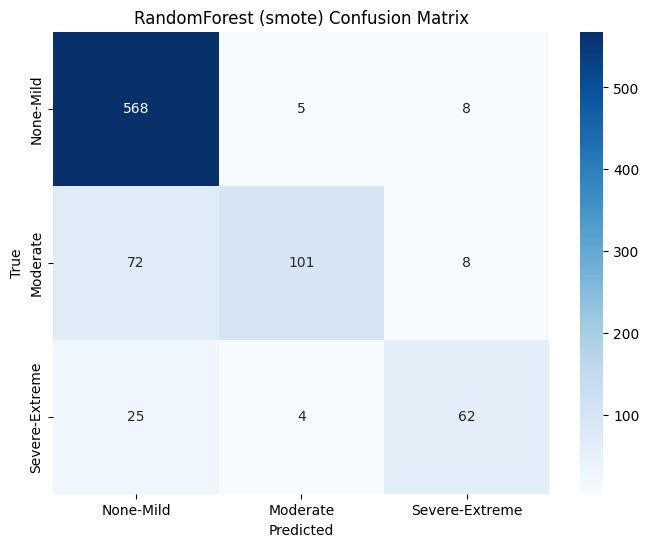

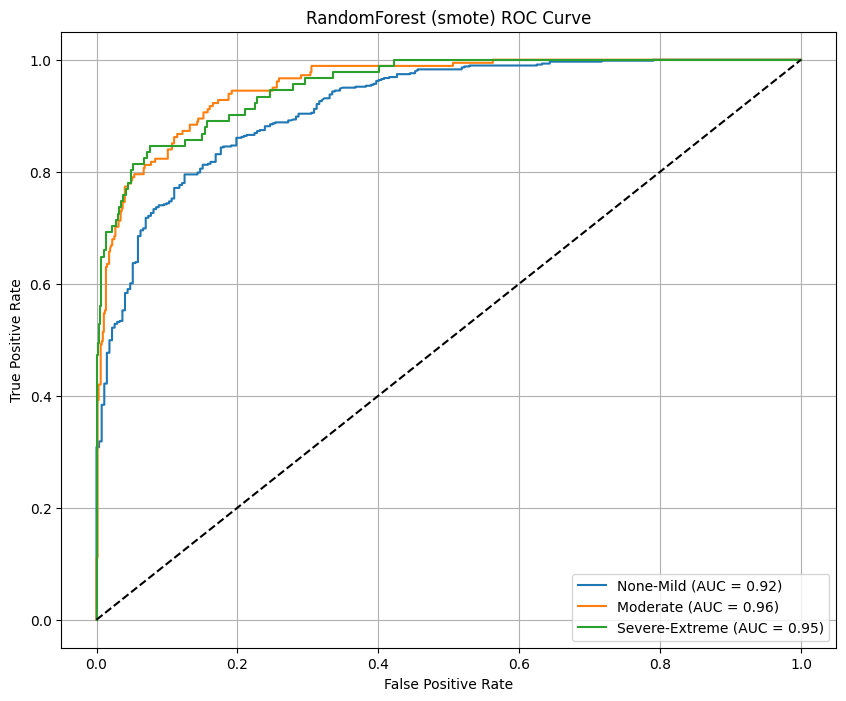

Performance for ExtraTrees (smote):
Accuracy: 0.84
                precision    recall  f1-score   support

     None-Mild       0.82      0.99      0.90       581
      Moderate       0.95      0.45      0.61       181
Severe-Extreme       0.85      0.64      0.73        91

      accuracy                           0.84       853
     macro avg       0.88      0.69      0.75       853
  weighted avg       0.85      0.84      0.82       853



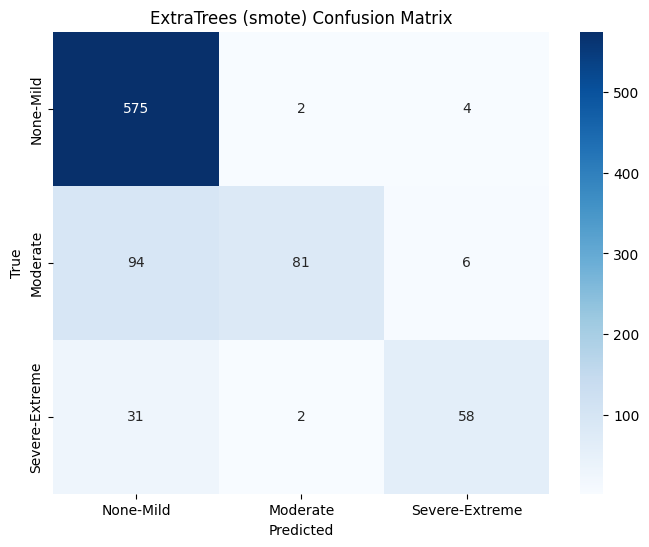

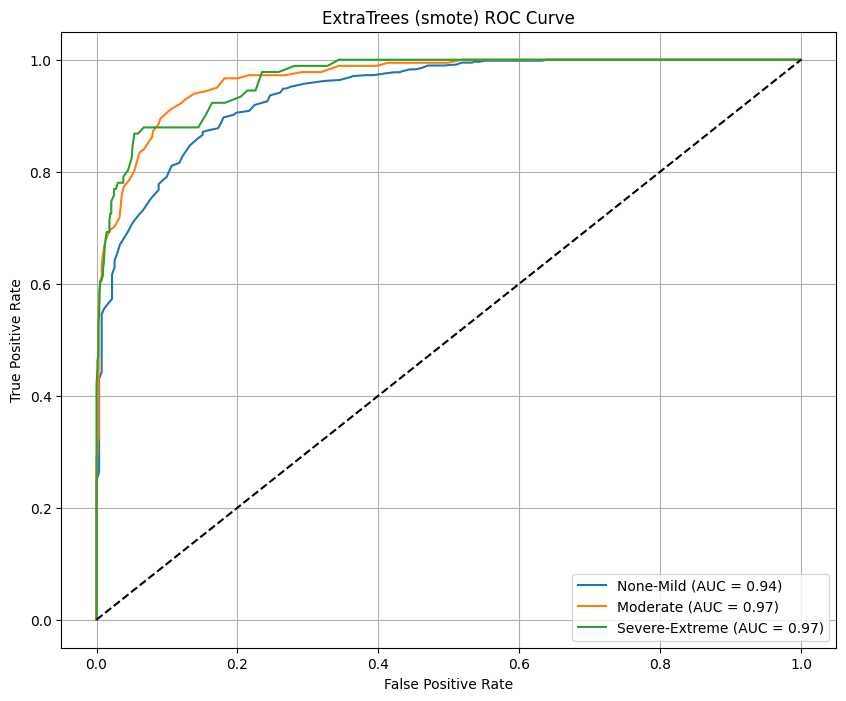

Performance for KNN (smote):
Accuracy: 0.83
                precision    recall  f1-score   support

     None-Mild       0.88      0.90      0.89       581
      Moderate       0.73      0.66      0.69       181
Severe-Extreme       0.69      0.75      0.72        91

      accuracy                           0.83       853
     macro avg       0.77      0.77      0.77       853
  weighted avg       0.83      0.83      0.83       853



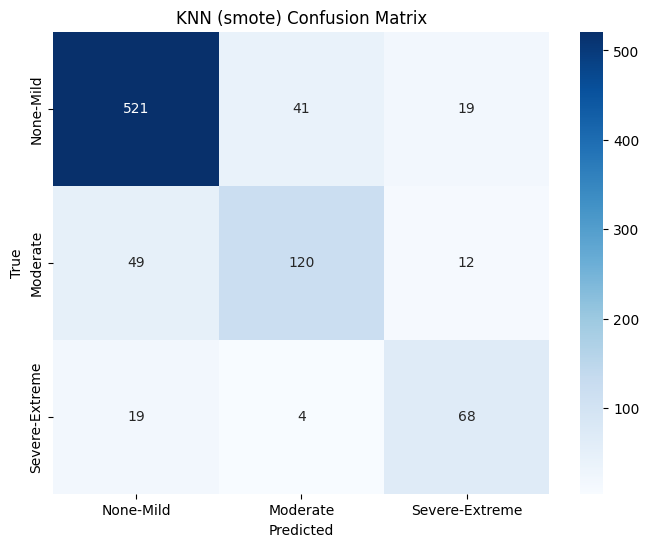

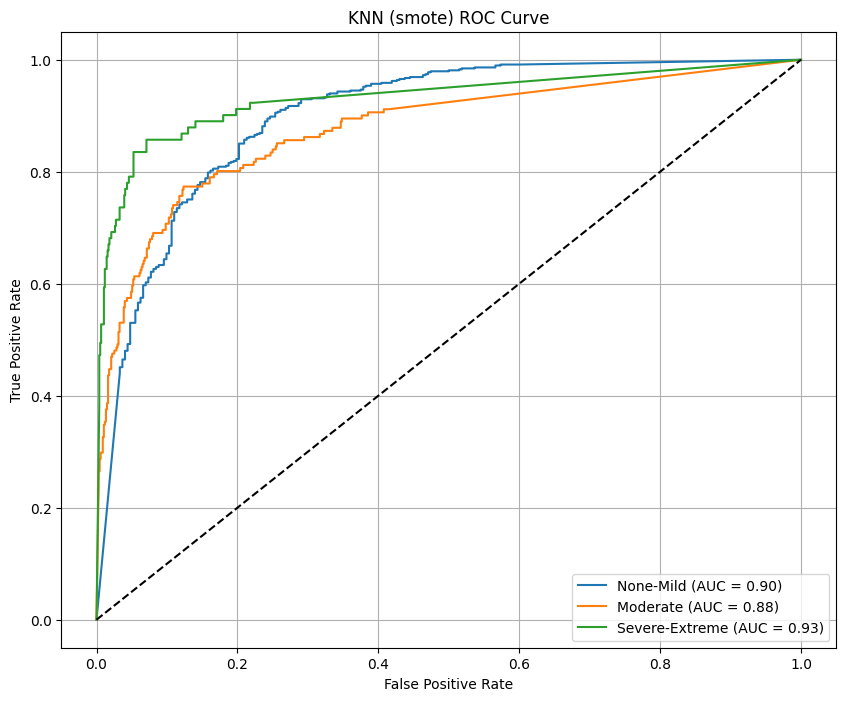

Performance for SVM (oversampled):
Accuracy: 0.82
                precision    recall  f1-score   support

     None-Mild       0.93      0.85      0.89       581
      Moderate       0.75      0.68      0.72       181
Severe-Extreme       0.54      0.95      0.69        91

      accuracy                           0.82       853
     macro avg       0.74      0.82      0.76       853
  weighted avg       0.85      0.82      0.83       853



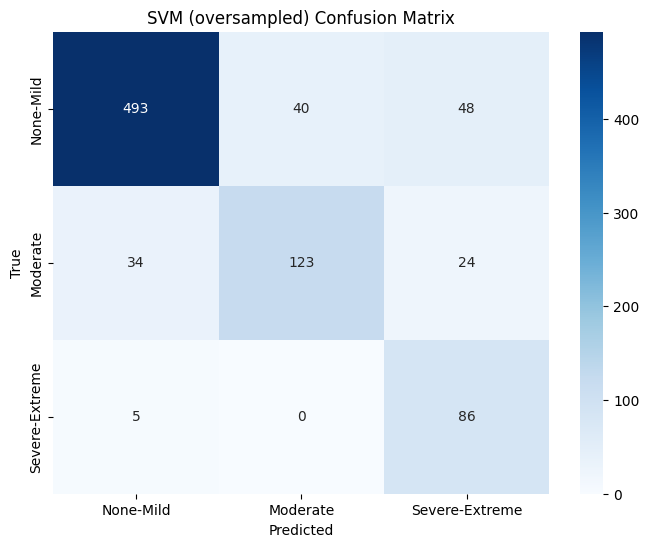

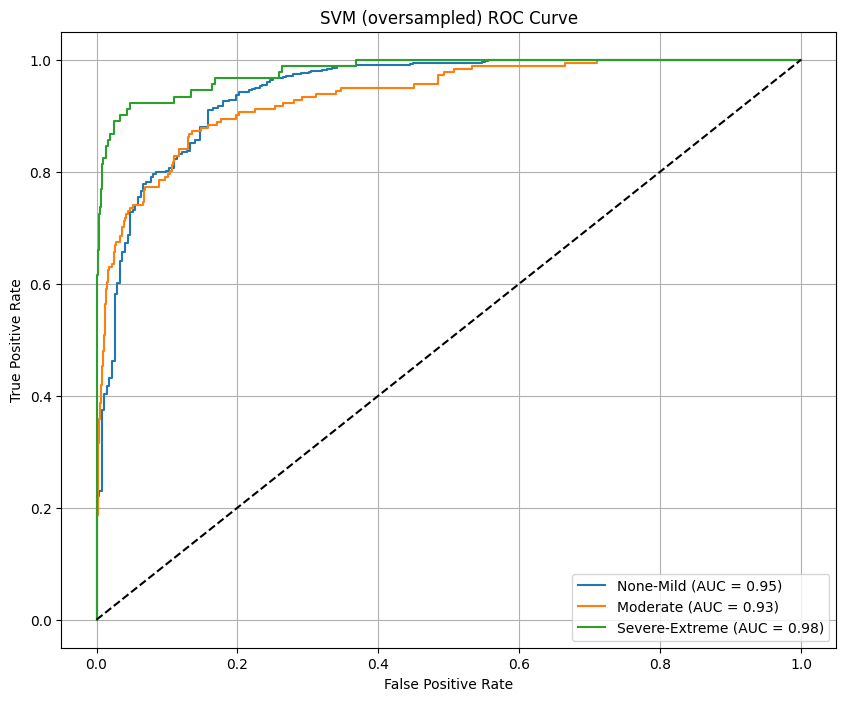

Performance for RandomForest (oversampled):
Accuracy: 0.81
                precision    recall  f1-score   support

     None-Mild       0.80      0.98      0.88       581
      Moderate       0.83      0.34      0.48       181
Severe-Extreme       0.85      0.64      0.73        91

      accuracy                           0.81       853
     macro avg       0.83      0.65      0.70       853
  weighted avg       0.81      0.81      0.78       853



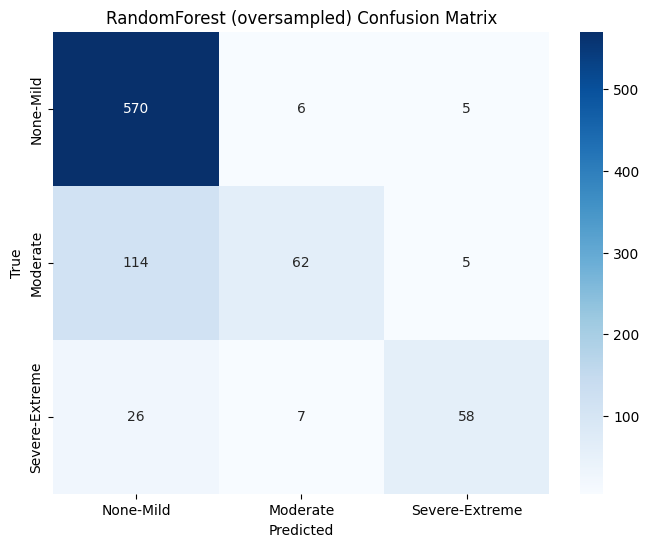

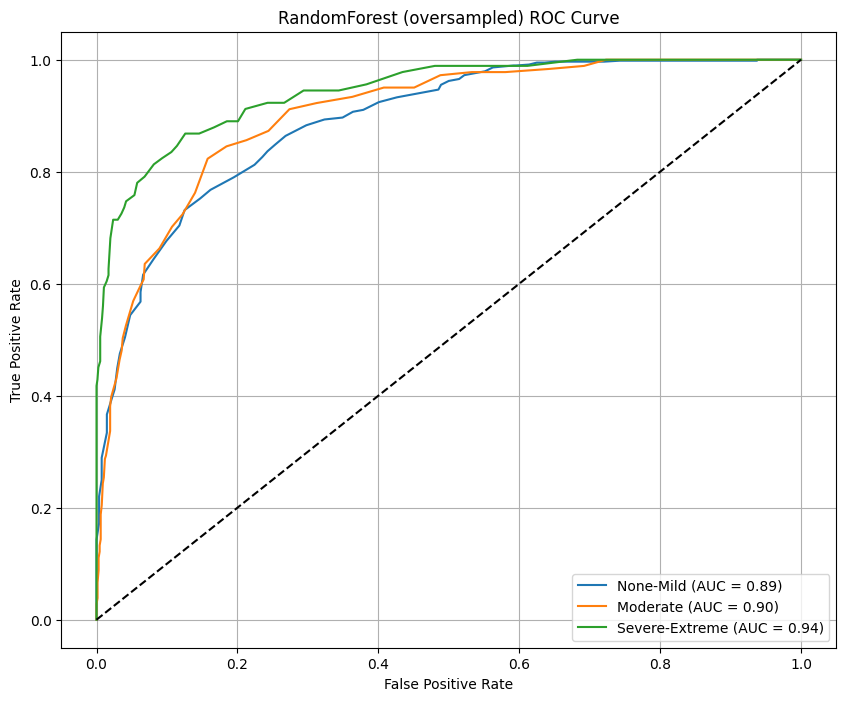

Performance for ExtraTrees (oversampled):
Accuracy: 0.77
                precision    recall  f1-score   support

     None-Mild       0.75      1.00      0.86       581
      Moderate       0.89      0.18      0.30       181
Severe-Extreme       1.00      0.45      0.62        91

      accuracy                           0.77       853
     macro avg       0.88      0.54      0.59       853
  weighted avg       0.81      0.77      0.71       853



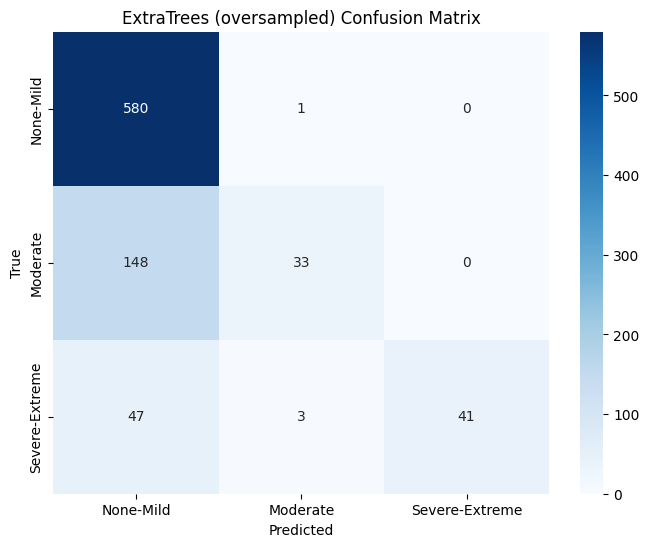

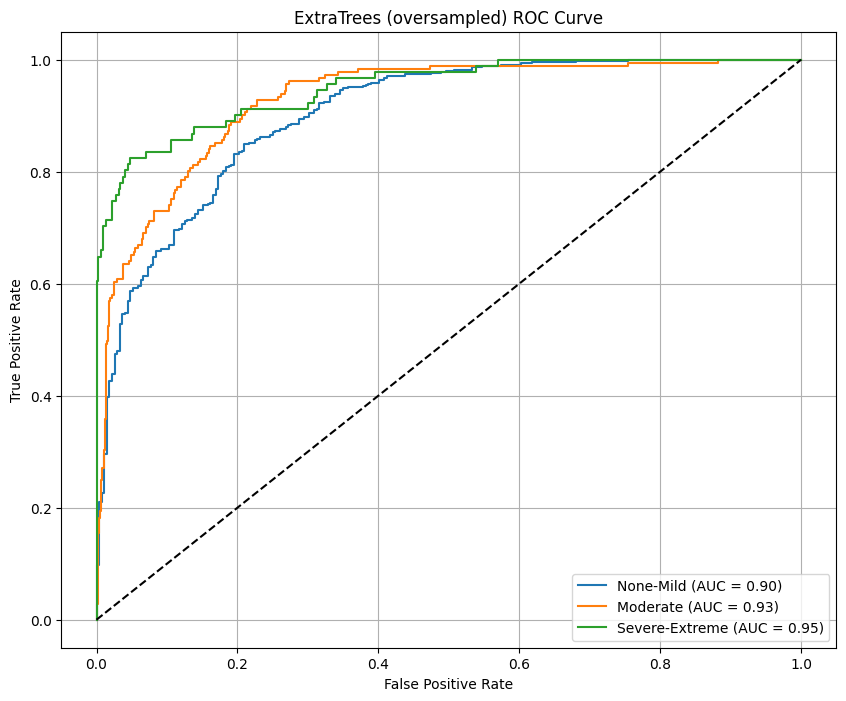

Performance for KNN (oversampled):
Accuracy: 0.74
                precision    recall  f1-score   support

     None-Mild       0.88      0.77      0.82       581
      Moderate       0.54      0.66      0.59       181
Severe-Extreme       0.54      0.71      0.61        91

      accuracy                           0.74       853
     macro avg       0.65      0.72      0.68       853
  weighted avg       0.77      0.74      0.75       853



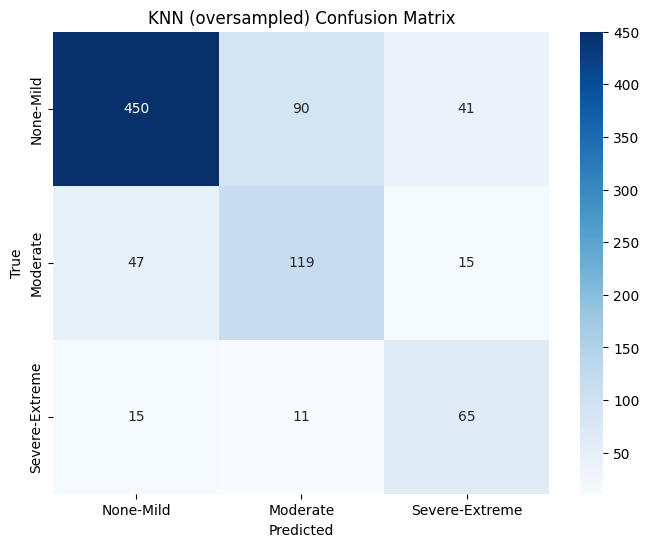

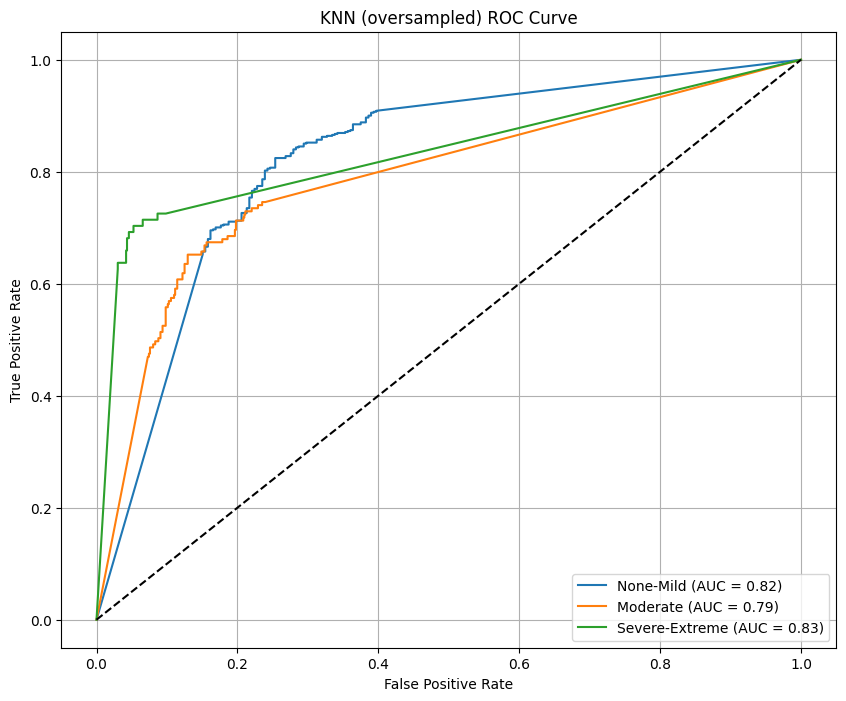

Performance for AdaBoost (smote):
Accuracy: 0.73
                precision    recall  f1-score   support

     None-Mild       0.83      0.83      0.83       581
      Moderate       0.48      0.47      0.48       181
Severe-Extreme       0.56      0.59      0.58        91

      accuracy                           0.73       853
     macro avg       0.63      0.63      0.63       853
  weighted avg       0.73      0.73      0.73       853



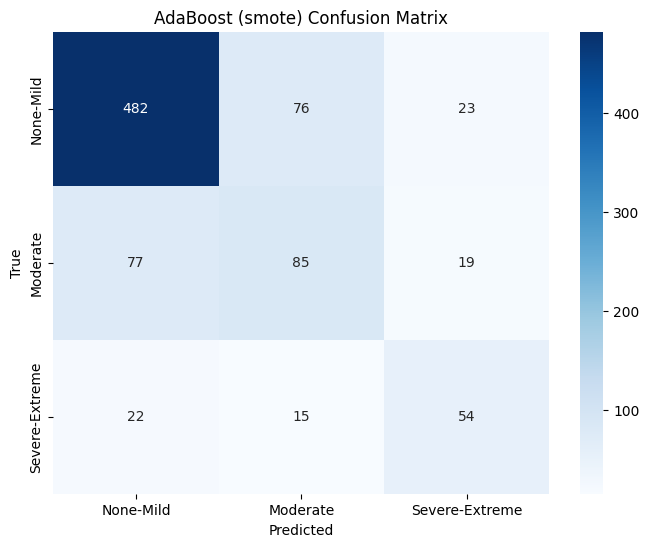

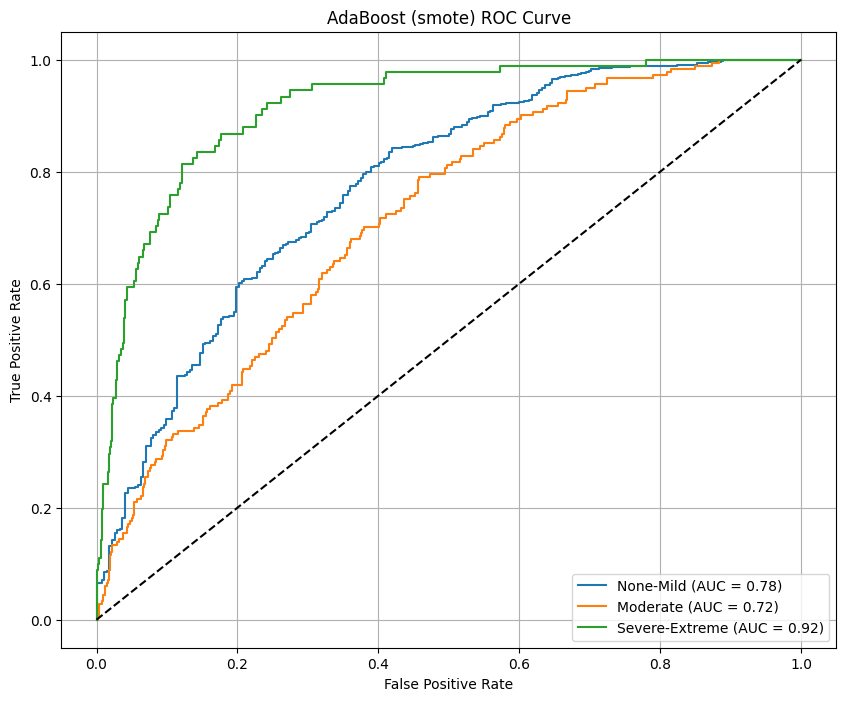

Performance for AdaBoost (oversampled):
Accuracy: 0.57
                precision    recall  f1-score   support

     None-Mild       0.85      0.60      0.70       581
      Moderate       0.33      0.41      0.37       181
Severe-Extreme       0.31      0.73      0.43        91

      accuracy                           0.57       853
     macro avg       0.50      0.58      0.50       853
  weighted avg       0.68      0.57      0.60       853



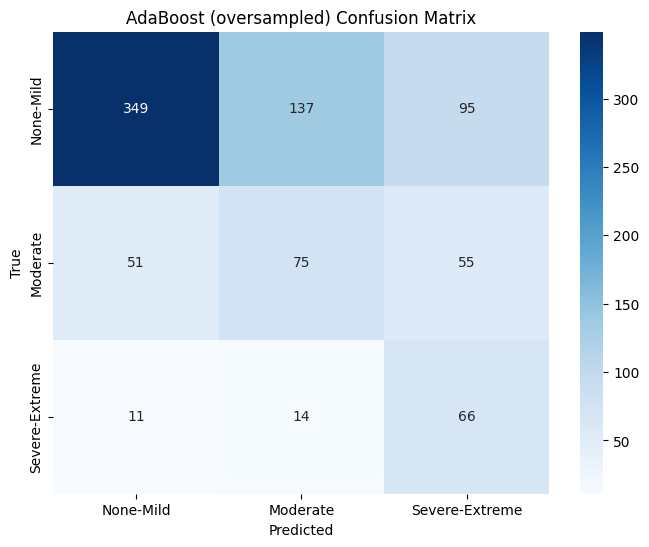

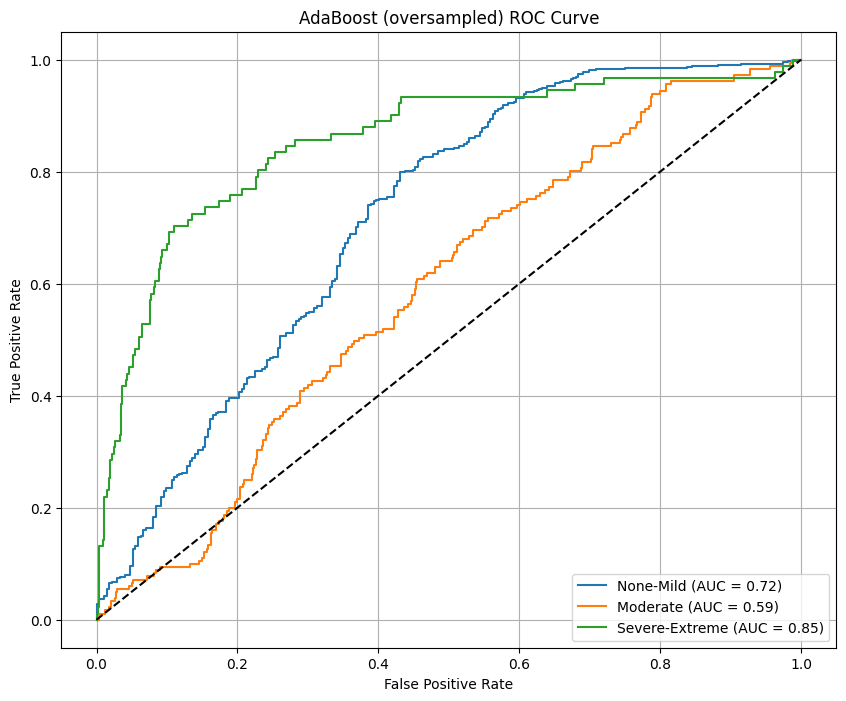

In [23]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_prob, class_names, title='ROC Curve'):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot graphs for top 3 performing models
top_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)[:10]
for result in top_results:
    model_name = result['model_name']
    y_test = result['y_test']
    y_pred = result['y_pred']
    y_prob = result['y_prob']
    
    print(f'Performance for {model_name}:')
    print(f'Accuracy: {result["accuracy"]:.2f}')
    print(classification_report(y_test, y_pred, target_names=["None-Mild", "Moderate", "Severe-Extreme"]))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, class_names=["None-Mild", "Moderate", "Severe-Extreme"], title=f'{model_name} Confusion Matrix')
    
    # ROC Curve
    if y_prob is not None:
        plot_roc_curve(y_test, y_prob, class_names=["None-Mild", "Moderate", "Severe-Extreme"], title=f'{model_name} ROC Curve')


### Creating model, predicting, calculating performance measures and drawing graphs

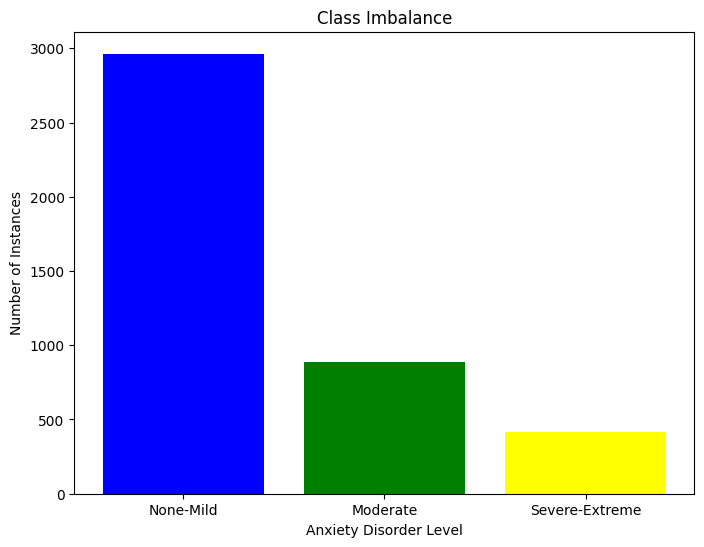

In [35]:
import matplotlib.pyplot as plt

# Class labels and counts
class_labels = ['None-Mild', 'Moderate', 'Severe-Extreme']
class_counts = [2964, 884, 416]

# Plotting the class imbalance
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=['blue', 'green', 'yellow', 'orange' , 'red'])
plt.xlabel('Anxiety Disorder Level')
plt.ylabel('Number of Instances')
plt.title('Class Imbalance')
plt.show()


# Graphs for EDA

In [41]:

df = edf.copy()
df['gad_scale'] = df['gad_scale'].map({'None-Mild': 'Mild-None', 'Moderate': 'Moderate', 'Severe-Extreme': 'Severe-Extreme'})

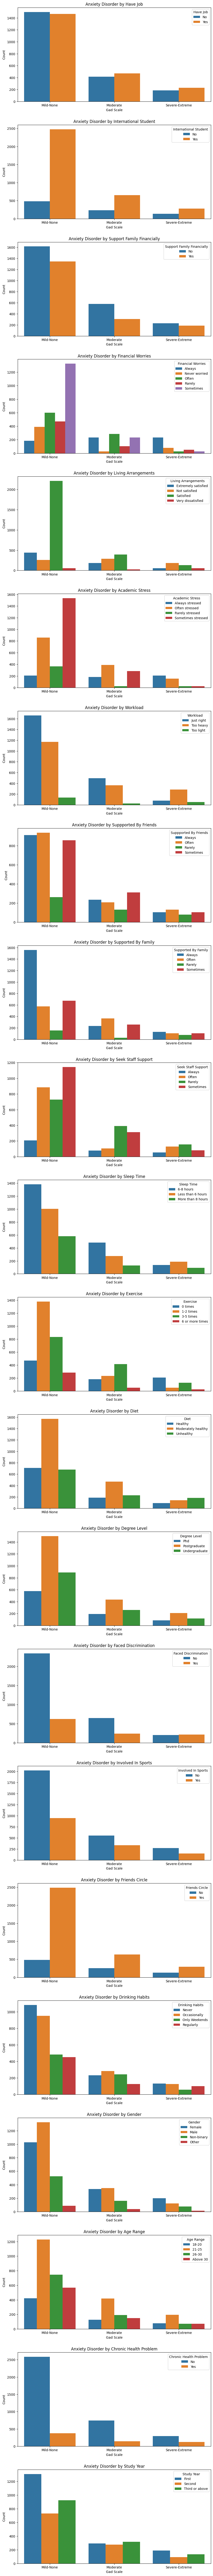

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dataframe is already loaded and named df

# Function to plot actual count plots and print values
def plot_actual_countplot(data, x, hue, title, ax):
    # Compute the actual count
    counts = data.groupby([x, hue]).size().rename('count').reset_index()
    sns.barplot(data=counts, x=x, y='count', hue=hue, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel(x.replace('_', ' ').title())
    ax.legend(title=hue.replace('_', ' ').title())
    

# List of columns to analyze
columns_to_analyze = ['have_job', 'international_student', 'support_family_financially',
       'financial_worries', 'living_arrangements', 'academic_stress',
       'workload', 'suppported_by_friends', 'supported_by_family',
       'seek_staff_support', 'sleep_time', 'exercise', 'diet', 'degree_level',
       'faced_discrimination', 'involved_in_sports', 'friends_circle',
       'drinking_habits', 'gender', 'age_range', 'chronic_health_problem',
       'study_year'
]

# Create subplots
fig, axes = plt.subplots(len(columns_to_analyze), 1, figsize=(10, 5 * len(columns_to_analyze)))
fig.tight_layout(pad=5.0)

# Plot each variable
for ax, column in zip(axes, columns_to_analyze):
    plot_actual_countplot(df, 'gad_scale', column, f'Anxiety Disorder by {column.replace("_", " ").title()}', ax)

plt.show()

# Save a summary of these visualizations in a multi-page PDF
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('anxiety_level_trends_actual.pdf') as pdf:
    for column in columns_to_analyze:
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_actual_countplot(df, 'gad_scale', column, f'Anxiety Disorder by {column.replace("_", " ").title()}', ax)
        pdf.savefig()
        plt.close()


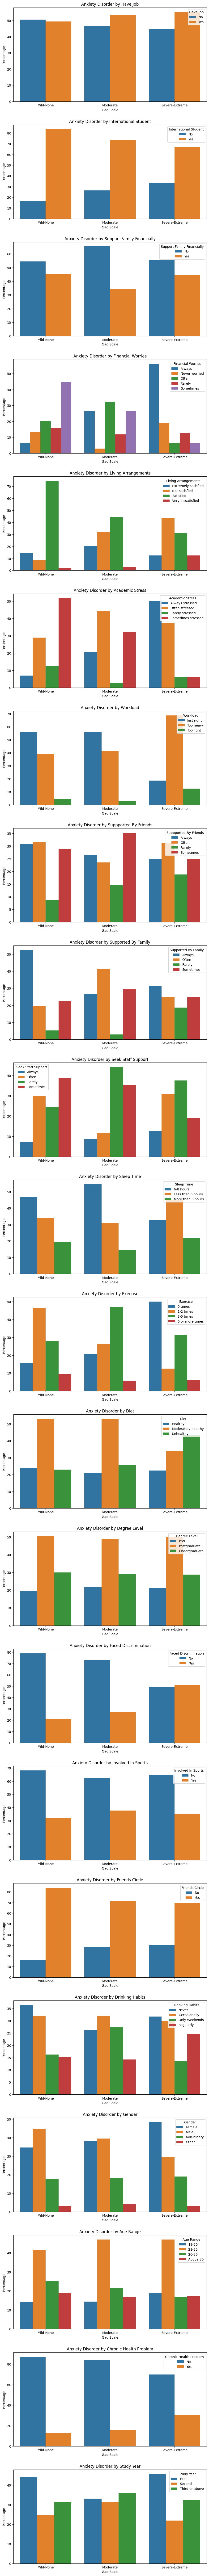

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dataframe is already loaded and named df

# Function to plot percentage count plots and print values
def plot_percentage_countplot(data, x, hue, title, ax):
    # Compute the actual count
    counts = data.groupby([x, hue]).size().rename('count').reset_index()
    # Calculate the percentage
    total_counts = counts.groupby(x)['count'].transform('sum')
    counts['percentage'] = (counts['count'] / total_counts) * 100
    
    # Plot the data
    sns.barplot(data=counts, x=x, y='percentage', hue=hue, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Percentage')
    ax.set_xlabel(x.replace('_', ' ').title())
    ax.legend(title=hue.replace('_', ' ').title())
    

# List of columns to analyze
columns_to_analyze = ['have_job', 'international_student', 'support_family_financially',
       'financial_worries', 'living_arrangements', 'academic_stress',
       'workload', 'suppported_by_friends', 'supported_by_family',
       'seek_staff_support', 'sleep_time', 'exercise', 'diet', 'degree_level',
       'faced_discrimination', 'involved_in_sports', 'friends_circle',
       'drinking_habits', 'gender', 'age_range', 'chronic_health_problem',
       'study_year'
]

# Create subplots
fig, axes = plt.subplots(len(columns_to_analyze), 1, figsize=(10, 5 * len(columns_to_analyze)))
fig.tight_layout(pad=5.0)

# Plot each variable
for ax, column in zip(axes, columns_to_analyze):
    plot_percentage_countplot(df, 'gad_scale', column, f'Anxiety Disorder by {column.replace("_", " ").title()}', ax)

plt.show()

# Save a summary of these visualizations in a multi-page PDF
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('anxiety_level_trends_actual.pdf') as pdf:
    for column in columns_to_analyze:
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_percentage_countplot(df, 'gad_scale', column, f'Anxiety Disorder by {column.replace("_", " ").title()}', ax)
        pdf.savefig()
        plt.close()
